In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('../data/processed/DecisionTreeData2010.csv', index_col=0)
#data = data.loc[data.Year > 2009]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,NetPrice,Cost,CONTROL_N,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
0,00100200,alabama a & m university,Normal,1,3,4,1,5.0,0.5129,4930.0,...,8190.0,13762.0,Public,xl,high,high,high,0.3306,0.7457,0.5000
1,00105200,university of alabama at birmingham,Birmingham,1,3,4,1,5.0,0.8243,10661.0,...,12838.0,18003.0,Public,xl,high,highest,highest,0.4108,0.7997,0.7000
2,02503400,amridge university,Montgomery,1,3,4,2,5.0,0.7143,370.0,...,16546.0,20700.0,Private nonprofit,medium,highest,med,low,0.2308,0.8000,NaN
3,00105500,university of alabama at huntsville,Huntsville,1,3,4,1,5.0,0.6614,5828.0,...,7752.0,17064.0,Public,xl,high,high,highest,0.4364,0.7545,0.5385
4,00100500,alabama state university,Montgomery,1,3,4,1,5.0,0.4372,4882.0,...,4061.0,14390.0,Public,xl,high,high,high,0.2399,0.6352,0.4167


In [3]:
# Separate open and closed schoools
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 32)

In [4]:
# Resample the minority class
from sklearn.utils import resample
closed_upsample = resample(closed, replace=True, n_samples=closed.shape[0]*2, random_state=123)

In [5]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(27923, 32)

In [6]:
current = open_df.loc[data.Year > 2012]
current.shape

(7440, 32)

In [7]:
data = pd.concat([current, closed_upsample], axis = 0)
data.shape

(12958, 32)

In [8]:
data.CURROPER.value_counts()

True     7440
False    5518
Name: CURROPER, dtype: int64

In [9]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins','CONTROL_N',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
22882,1,3,1,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
22883,1,3,1,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
22884,1,3,2,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.037529,10500.0,12300.0,0.6667,0.3750
22885,1,3,1,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
22886,1,3,1,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12958 entries, 22882 to 6665
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          12958 non-null  int64  
 1   PREDDEG            12958 non-null  int64  
 2   CONTROL            12958 non-null  int64  
 3   UGDS               12958 non-null  float64
 4   CURROPER           12958 non-null  bool   
 5   TUITFTE            12958 non-null  float64
 6   INEXPFTE           12958 non-null  float64
 7   PFTFAC             12958 non-null  float64
 8   UG25abv            12958 non-null  float64
 9   COMP_ORIG_YR4_RT   12958 non-null  float64
 10  WDRAW_ORIG_YR4_RT  12958 non-null  float64
 11  ENRL_ORIG_YR4_RT   12958 non-null  float64
 12  DEBT_MDN           12958 non-null  float64
 13  Cost               12958 non-null  float64
 14  Complete           12958 non-null  float64
 15  RetentionFT        12958 non-null  float64
dtypes: bool(1), float64

In [11]:
df.isnull().sum()

NUMBRANCH            0
PREDDEG              0
CONTROL              0
UGDS                 0
CURROPER             0
TUITFTE              0
INEXPFTE             0
PFTFAC               0
UG25abv              0
COMP_ORIG_YR4_RT     0
WDRAW_ORIG_YR4_RT    0
ENRL_ORIG_YR4_RT     0
DEBT_MDN             0
Cost                 0
Complete             0
RetentionFT          0
dtype: int64

In [12]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [14]:
X_test.shape

(3888, 15)

# Decision Tree Model
Basis for comparison

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [16]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [17]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
    crit = 'gini'
else:
    depth = max_depth[entropy_idx]
    crit='entropy'
    
print(depth)

24


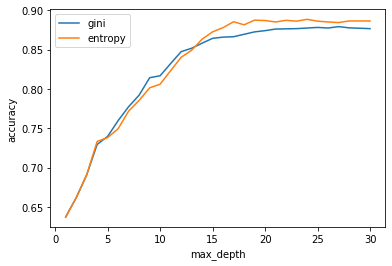

In [18]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=24, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [20]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict_proba(X_test)
#print(type(dt_pred_prob))

In [21]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.8886316872427984
Balanced accuracy: 0.8927945301542777
Precision score for "Yes" 0.9364386220281417
Recall score for "No" 0.9208937198067633


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[1525  131]
 [ 302 1930]]


In [23]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.83      0.92      0.88      1656
        True       0.94      0.86      0.90      2232

    accuracy                           0.89      3888
   macro avg       0.89      0.89      0.89      3888
weighted avg       0.89      0.89      0.89      3888



In [24]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDT.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature UGDS (0.135399)
2. feature CONTROL (0.094133)
3. feature INEXPFTE (0.088319)
4. feature UG25abv (0.088138)
5. feature TUITFTE (0.080195)
6. feature WDRAW_ORIG_YR4_RT (0.078157)
7. feature DEBT_MDN (0.074085)
8. feature Cost (0.065032)
9. feature Complete (0.060034)
10. feature COMP_ORIG_YR4_RT (0.058083)
11. feature NUMBRANCH (0.050853)
12. feature RetentionFT (0.049915)
13. feature PFTFAC (0.034171)
14. feature ENRL_ORIG_YR4_RT (0.029694)
15. feature PREDDEG (0.013791)


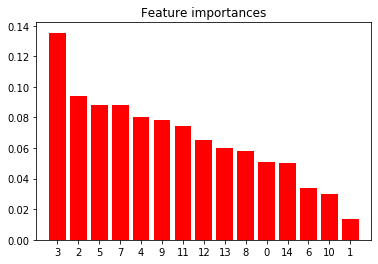

In [25]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center") #yerr=std[indices]
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

CONTROL and UGDS are the most prominent features - that predict open schools. (Control is categorical, so I'm not exactly sure how to interpret it). More enrollment increases prediction of being open.

## Decision Tree Model with various thresholds

In [26]:
threshold = []
accurate=[]
balance_acc = []
pred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(dt_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(dt_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    accurate.append(metrics.accuracy_score(y_test, new_pred))
    balance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    threshold.append(thresh)
    pred_proba.append(new_pred)

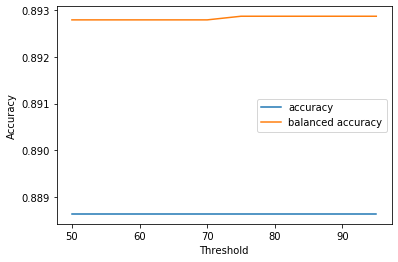

In [27]:
rate = pd.DataFrame({'threshold':pd.Series(threshold),
                     'accuracy':pd.Series(accurate),
                     'balance_acc':pd.Series(balance_acc)})

plt.plot('threshold', 'accuracy', data=rate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=rate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
print("Balance Accuracy: ", max(balance_acc))
idx = balance_acc.index(max(balance_acc))
print("Threshold: ", threshold[idx])

Balance Accuracy:  0.8928724481845098
Threshold:  75


## AdaBoost model

In [29]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

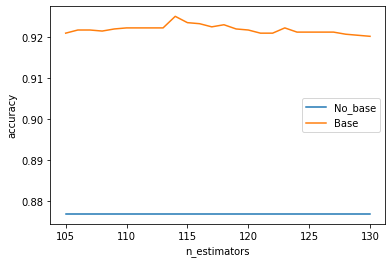

In [30]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [31]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

114


In [32]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.9251543209876543


In [33]:
print(confusion_matrix(y_test, AB_pred))

[[1536  120]
 [ 171 2061]]


In [34]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.90      0.93      0.91      1656
        True       0.94      0.92      0.93      2232

    accuracy                           0.93      3888
   macro avg       0.92      0.93      0.92      3888
weighted avg       0.93      0.93      0.93      3888



In [35]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature RetentionFT (nan)
2. feature Cost (nan)
3. feature DEBT_MDN (nan)
4. feature ENRL_ORIG_YR4_RT (nan)
5. feature WDRAW_ORIG_YR4_RT (nan)
6. feature COMP_ORIG_YR4_RT (nan)
7. feature UG25abv (nan)
8. feature PFTFAC (nan)
9. feature INEXPFTE (nan)
10. feature TUITFTE (nan)
11. feature UGDS (nan)
12. feature PREDDEG (nan)
13. feature NUMBRANCH (nan)
14. feature CONTROL (-0.024307)
15. feature Complete (-0.055621)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


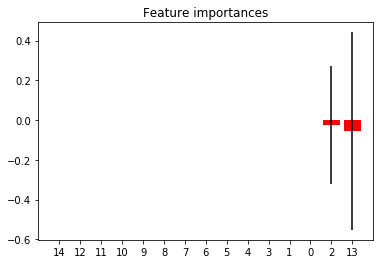

In [36]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Explore different threshold values for AB Model

In [37]:
AB_pred_prob = modelAB.predict_proba(X_test)

ABthreshold = []
ABaccurate=[]
ABbalance_acc = []
ABpred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(AB_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(AB_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    ABaccurate.append(metrics.accuracy_score(y_test, new_pred))
    ABbalance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    ABthreshold.append(thresh)
    ABpred_proba.append(new_pred)

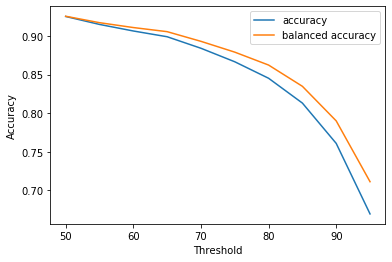

In [38]:
ABrate = pd.DataFrame({'threshold':pd.Series(ABthreshold),
                     'accuracy':pd.Series(ABaccurate),
                     'balance_acc':pd.Series(ABbalance_acc)})

plt.plot('threshold', 'accuracy', data=ABrate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=ABrate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 224 schools in this class that could be explored further.

In [39]:
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
29518,True,True
25278,True,True
26172,True,True
4329,False,False
25384,True,True


In [40]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
29518,4,1,3,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,0.000000,12417.0,26213.0,0.3636,0.6364,True,True
25278,1,1,3,270.0,5128.0,6008.0,0.4375,0.5444,0.446097,0.289963,0.000000,4857.0,15973.0,0.5523,0.6552,True,True
26172,1,2,3,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,0.018041,9500.0,22907.0,0.2300,0.6129,True,True
4329,1,1,3,129.0,7651.0,8874.0,0.4375,0.2479,0.576687,0.239264,0.000000,10885.0,38377.0,0.6124,0.6429,False,False
25384,1,2,1,3381.0,2635.0,5570.0,0.2457,0.2190,0.296157,0.247174,0.020231,5906.0,13481.0,0.3339,0.6095,True,True


In [41]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(120, 17)

In [42]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(171, 17)

## Generate graphs for the report

In [43]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

29518    TP
25278    TP
26172    TP
4329     TN
25384    TP
         ..
26843    TP
22649    TN
27248    TP
14348    TN
29292    TP
Name: Result, Length: 3888, dtype: object


In [44]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,AVGFACSAL,PCTFLOAN,Year,NetPrice,CONTROL_N,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,4,1,3,172.0,11067.0,6322.0,0.4000,0.7151,0.558824,0.214286,...,3611.0,0.8580,2013,21431.0,Private for-profit,medium,highest,high,low,NaN
1,1,1,3,270.0,5128.0,6008.0,0.4375,0.5444,0.446097,0.289963,...,NaN,0.8523,2013,12903.0,Private for-profit,medium,med,high,NaN,NaN
2,1,2,3,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,...,4376.0,0.6365,2013,18273.0,Private for-profit,large,high,med,med,NaN
3,1,1,3,129.0,7651.0,8874.0,0.4375,0.2479,0.576687,0.239264,...,NaN,0.9190,2010,12618.0,Private for-profit,small,high,high,NaN,0.6667
4,1,2,1,3381.0,2635.0,5570.0,0.2457,0.2190,0.296157,0.247174,...,6598.0,0.2513,2013,7722.0,Public,xl,med,med,high,0.3977


In [45]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7543 entries, 0 to 7542
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          7543 non-null   int64  
 1   PREDDEG            7543 non-null   object 
 2   CONTROL            7543 non-null   object 
 3   UGDS               7543 non-null   float64
 4   TUITFTE            7543 non-null   float64
 5   INEXPFTE           7543 non-null   float64
 6   PFTFAC             7543 non-null   float64
 7   UG25abv            7543 non-null   float64
 8   COMP_ORIG_YR4_RT   7543 non-null   float64
 9   WDRAW_ORIG_YR4_RT  7543 non-null   float64
 10  ENRL_ORIG_YR4_RT   7543 non-null   float64
 11  DEBT_MDN           7543 non-null   float64
 12  Cost               7543 non-null   float64
 13  Complete           7543 non-null   float64
 14  RetentionFT        7543 non-null   float64
 15  CURROPER           7543 non-null   bool   
 16  Predicted          7543 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
to_graph.duplicated().sum()

3912

In [47]:
to_graph.drop_duplicates(inplace=True)
to_graph.shape

(3631, 30)

In [48]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL     1                       2                        3               \
Result     FN   FP    TN     TP    FN    FP    TN     TP    FN    FP     TN   
PREDDEG                                                                       
0         1.0  1.0  17.0   31.0   9.0   NaN  20.0   54.0   9.0   4.0   96.0   
1        11.0  3.0  56.0  167.0  12.0   6.0  65.0   38.0  97.0  51.0  642.0   
2         NaN  2.0  19.0  215.0   3.0   3.0  10.0   49.0  17.0   7.0  107.0   
3         NaN  2.0   1.0  167.0   7.0  11.0  32.0  368.0   6.0   NaN   72.0   
4         NaN  NaN   NaN    4.0   2.0   NaN  20.0   77.0   1.0   NaN   30.0   

CONTROL         
Result      TP  
PREDDEG         
0        154.0  
1        617.0  
2        158.0  
3         72.0  
4          8.0  


In [49]:
controlPivot = to_graph.pivot_table(index='CONTROL_N', columns = 'Result', aggfunc='size')
print(controlPivot)

Result               FN  FP   TN    TP
CONTROL_N                             
Private for-profit  130  62  947  1009
Private nonprofit    33  20  147   586
Public               12   8   93   584


In [50]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,CITY,HIGHDEG,region,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,CONTROL_N,RetentionPT
19,2,0,3,73.0,1216.0,3999.0,0.25265,0.4521,0.343499,0.313228,...,Huntington Park,0,8.0,NaN,NaN,0.7250,2013,8950.0,Private for-profit,NaN
124,2,2,3,1885.0,17502.0,2582.0,0.13130,0.5095,0.394105,0.319869,...,Bethpage,3,2.0,NaN,5611.0,0.8827,2013,14620.0,Private for-profit,0.1667
238,2,1,3,64.0,5445.0,9925.0,0.43750,0.4063,0.307393,0.291829,...,Chambersburg,1,2.0,NaN,NaN,0.5625,2013,14931.0,Private for-profit,0.7778
287,6,3,2,56.0,20121.0,11601.0,0.21880,0.6071,0.465000,0.151515,...,Riverhead,4,2.0,NaN,9735.0,0.7843,2013,19764.5,Private nonprofit,NaN
294,1,1,3,17.0,7863.0,4453.0,0.43750,0.4706,0.538462,0.173333,...,Yukon,1,6.0,NaN,NaN,0.9500,2013,7705.0,Private for-profit,NaN


## UGDS - Undergraduate enrollment

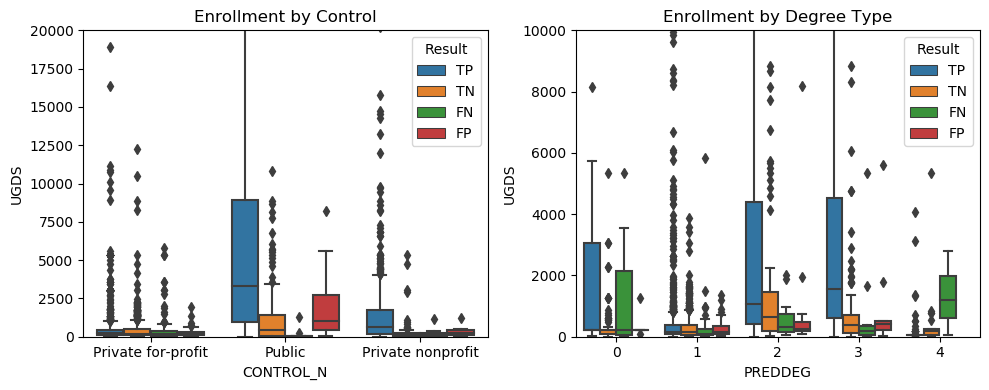

In [51]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL_N', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

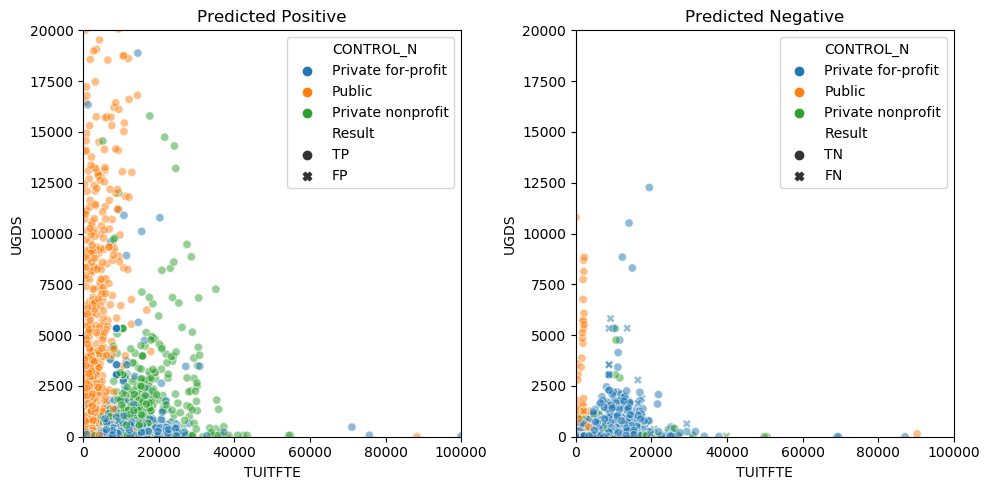

In [52]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'CONTROL_N',style='Result', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'CONTROL_N', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)
plt.tight_layout()
#plt.show()
plt.savefig('../figures/TuitionEnrollmentResultsControl.png',bbox_inches='tight')

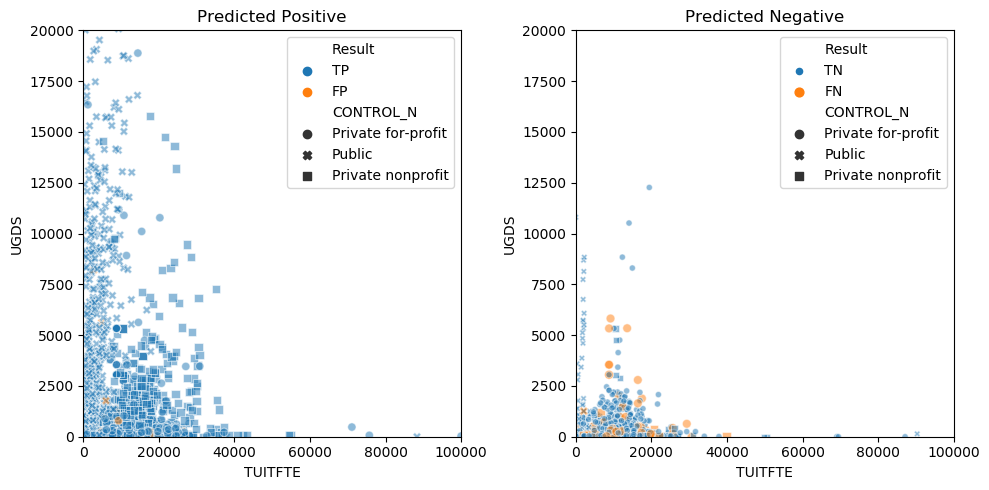

In [53]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result',style='CONTROL_N', alpha=0.5 )
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,20000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='CONTROL_N',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,20000)
plt.tight_layout()
#plt.show()
plt.savefig('../figures/TuitionEnrollmentResults.png',bbox_inches='tight')

## Tuition and Cost

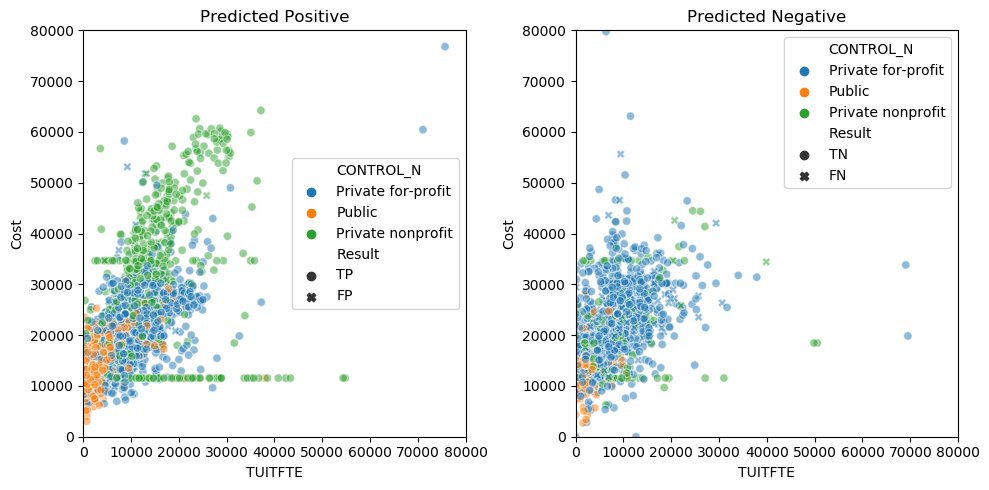

In [54]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='CONTROL_N', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'CONTROL_N', style='Result', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.savefig('../figures/TuitionCostResultsControl.png',bbox_inches='tight')

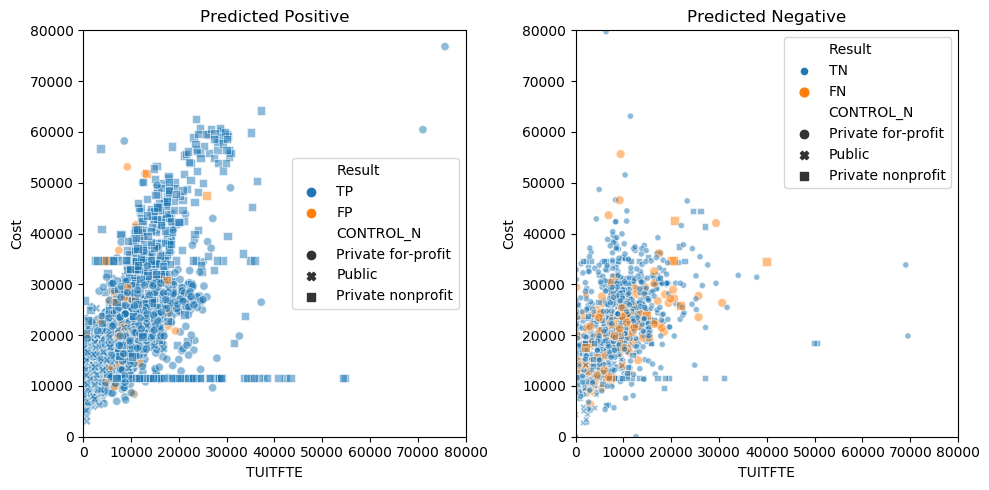

In [55]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue ='Result', style='CONTROL_N', alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='CONTROL_N',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.savefig('../figures/TuitionCostResults.png',bbox_inches='tight')

## Cost and Debt

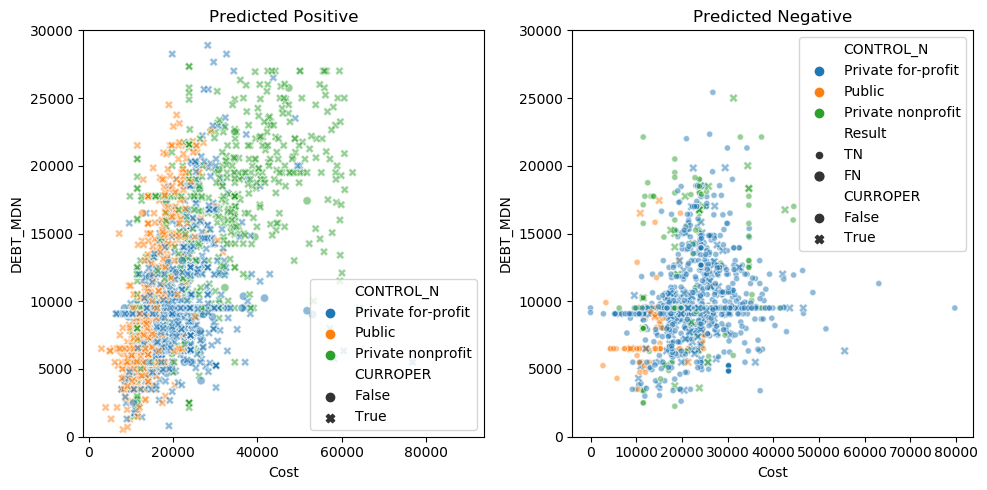

In [56]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL_N', style='CURROPER', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='CONTROL_N', style='CURROPER',size='Result', sizes={20,40}, alpha=0.5) #, label='True')
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.tight_layout()

#plt.show()
plt.savefig('../figures/CostDebtResultsControl.png',bbox_inches='tight')

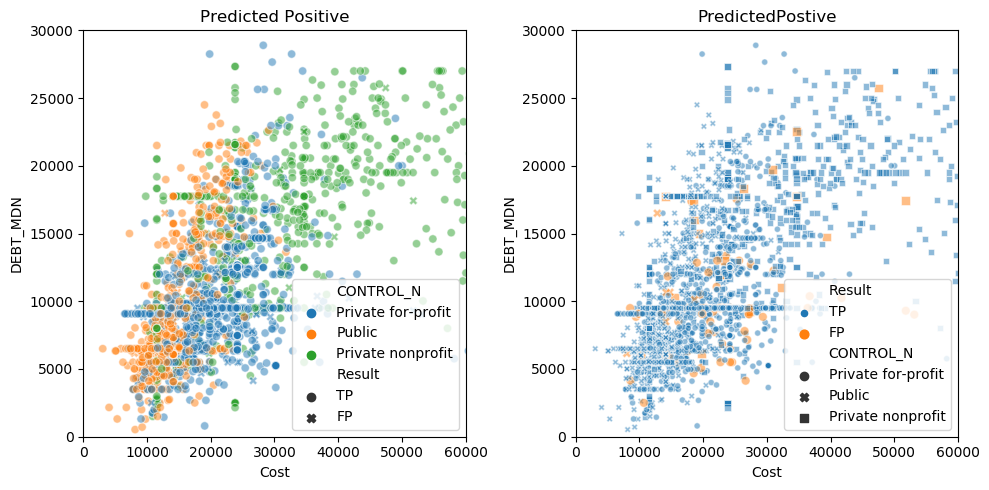

In [57]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL_N', style='Result', alpha=0.5)
plt.title('Predicted Positive')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='CONTROL_N',size='Result', sizes={20,40}, alpha=0.5)
plt.title('PredictedPostive')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
#plt.show()
plt.savefig('../figures/TuitionCostResultsPositive.png',bbox_inches='tight')

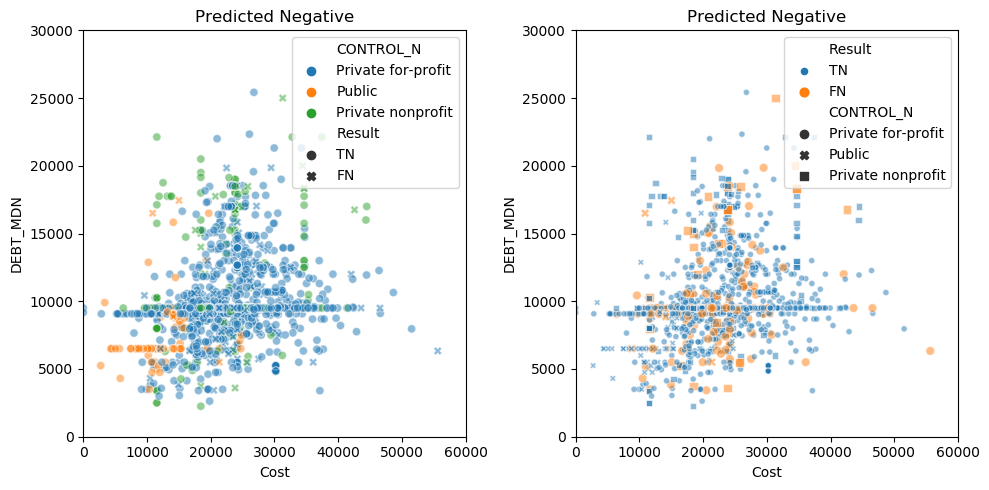

<Figure size 432x288 with 0 Axes>

In [58]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='CONTROL_N', style='Result', alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='CONTROL_N', size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()
plt.savefig('../figures/TuitionCostResultsNegative.png',bbox_inches='tight')

## NumBranch

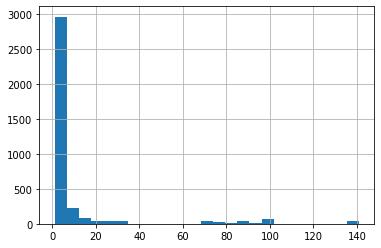

In [59]:
to_graph.NUMBRANCH.hist(bins=25)

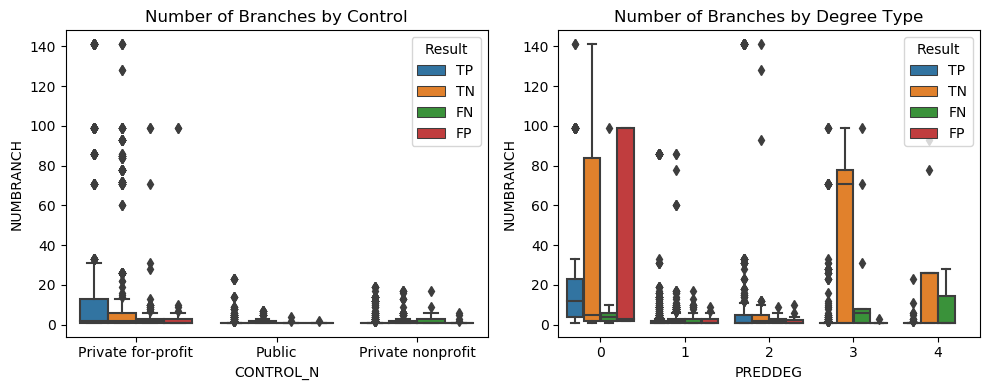

In [60]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL_N', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Degree Type')
plt.tight_layout()
plt.show()

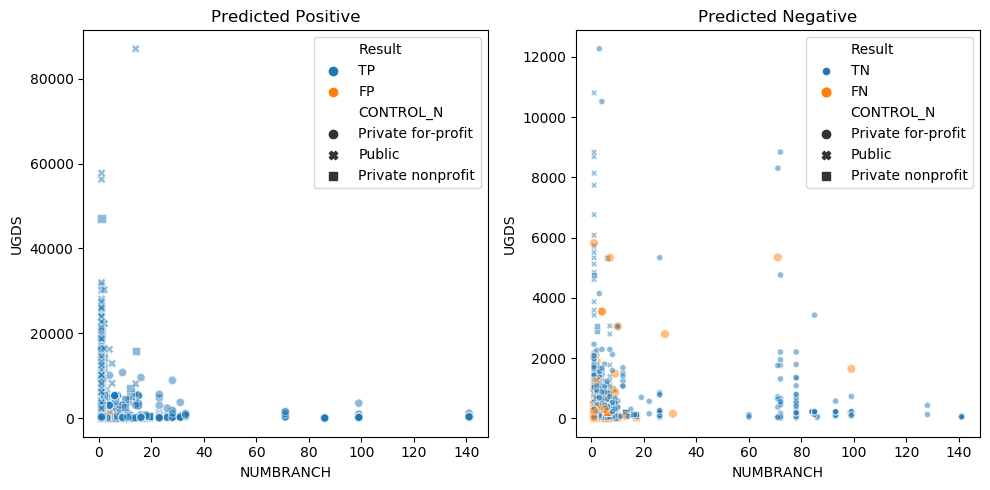

<Figure size 432x288 with 0 Axes>

In [61]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='CONTROL_N', alpha=0.5)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='CONTROL_N',size='Result', sizes={20,40}, alpha=0.5)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()
plt.savefig('../figures/NumBranchUGDSResults.png',bbox_inches='tight')

## Instructional Expenditure

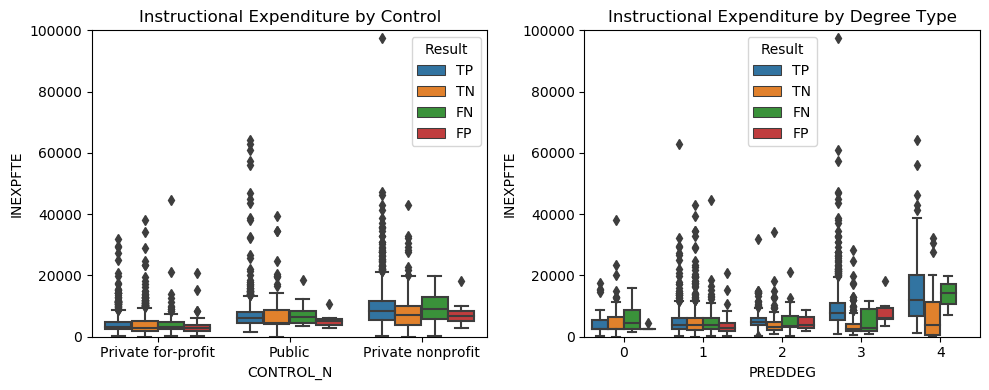

In [62]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL_N', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()
plt.show()

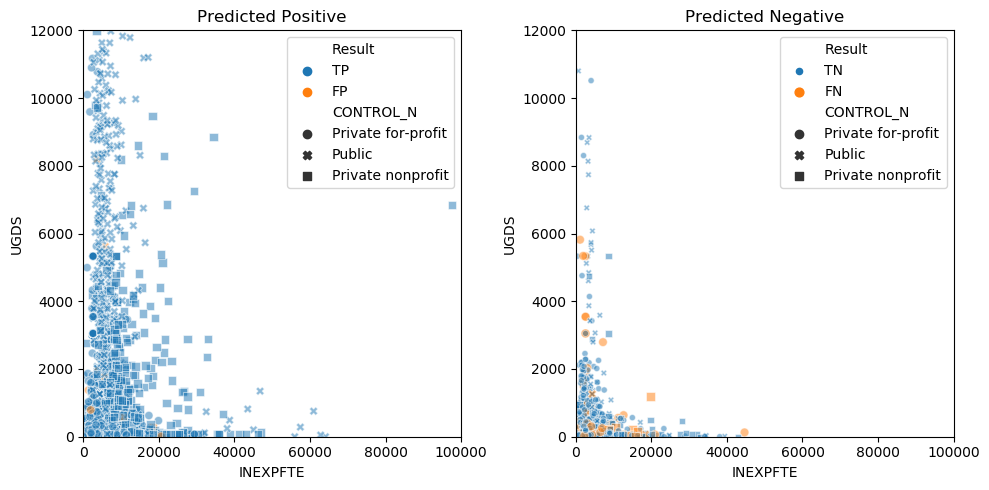

In [63]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('', 'UGDS', data=to_graph, hue = 'Result')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='CONTROL_N', alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue='Result', style='CONTROL_N',size='Result', sizes={20,40}, alpha=0.5)
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('Predicted Negative')
plt.tight_layout()
#plt.show()
plt.savefig('../figures/ExpenditureUGDSResults.png',bbox_inches='tight')

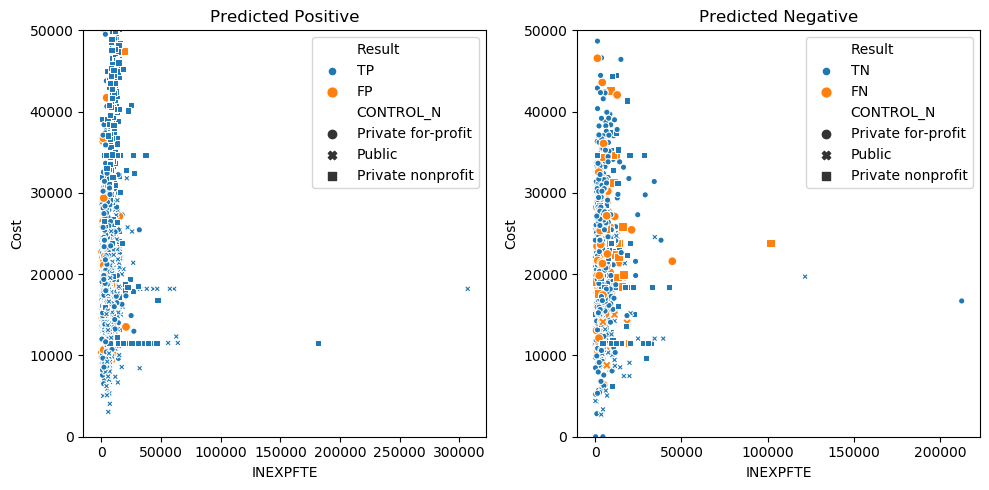

In [64]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue='Result', style='CONTROL_N',size='Result', sizes={20,40})#, alpha=0.5)
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result', style='CONTROL_N', size='Result', sizes={20,40})
plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
#plt.show()
plt.savefig('../figures/ExpenditureCostResultsPositive.png',bbox_inches='tight')